# Santa's workshop tour 2019 : Exploratory Data Analysis

<br>
link : https://www.kaggle.com/c/santa-workshop-tour-2019/overview

In [2]:
# setup python path
import sys
sys.path.append('/home/r2d9/workshop')

In [3]:
# built-in packages
import os
# external packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# custom package
from workshop.settings import DATA_PATH

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Data loading

In [5]:
data = pd.read_csv(os.path.join(DATA_PATH, 'family_data.csv'), index_col='family_id')

In [13]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


## Basic information

In [14]:
data.isna().sum()

choice_0    0
choice_1    0
choice_2    0
choice_3    0
choice_4    0
choice_5    0
choice_6    0
choice_7    0
choice_8    0
choice_9    0
n_people    0
dtype: int64

In [15]:
data.dtypes

choice_0    int64
choice_1    int64
choice_2    int64
choice_3    int64
choice_4    int64
choice_5    int64
choice_6    int64
choice_7    int64
choice_8    int64
choice_9    int64
n_people    int64
dtype: object

In [30]:
data.shape

(5000, 11)

## Analysis (Part 1)

### number of people per group

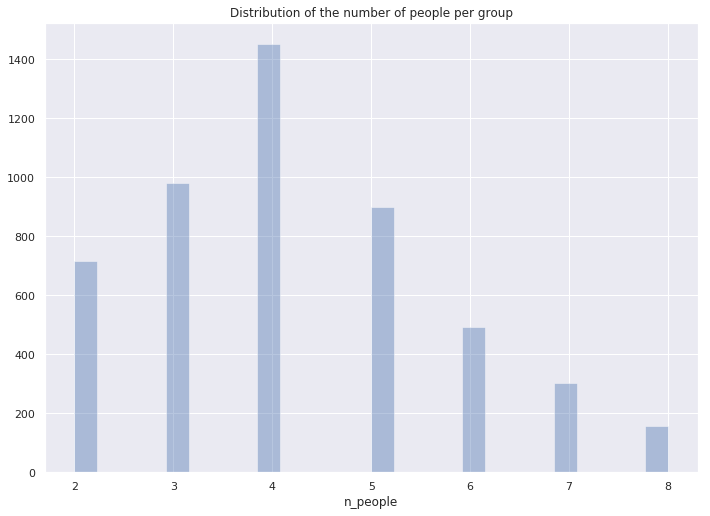

In [40]:
sns.distplot(data["n_people"], kde=False);

In [24]:
data["n_people"].describe()

count    5000.00000
mean        4.20060
std         1.53272
min         2.00000
25%         3.00000
50%         4.00000
75%         5.00000
max         8.00000
Name: n_people, dtype: float64

### number of people (group wish * number of people) per day (1 to 100) - all wishes considered

In [51]:
preferred_days_visits = pd.Series(0, index=[i for i in range(1, 101)], name="n_people")
for row_idx, row in data.iterrows():
    n_people = row.n_people
    choices = row.drop("n_people")
    for choice in choices:
        preferred_days_visits.loc[choice] += n_people

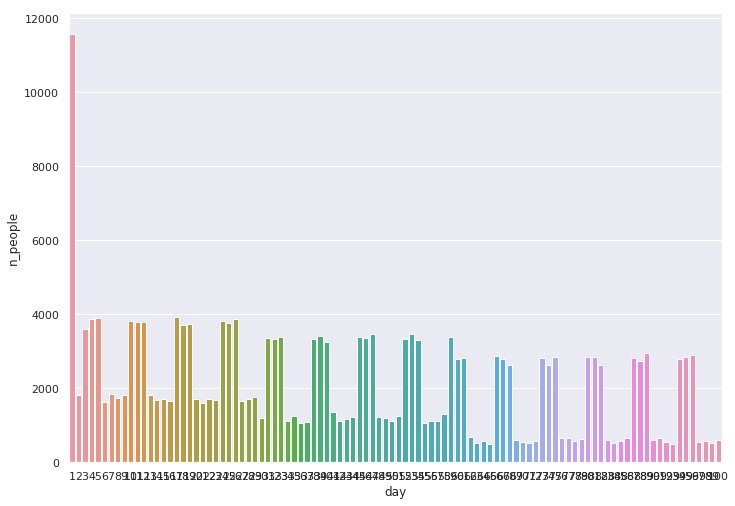

In [54]:
preferred_days_visits = preferred_days_visits.reset_index().rename({"index": "day"}, axis=1)
sns.barplot(data=preferred_days_visits, x="day", y="n_people")

### observations
- Majority of groups from 3 to 5 people
- There is a nice peak at Christmas Eve (day 1)
- We observe a trend as the number of wishes grows as we move towards Christmas
- We also observe seasonality as every week-end the number of wishes is much higher than during the week

## Analysis (Part 2)
So far, we did not consider the order in which each group make wishes. Since our cost function is heavily dependent on the ranking of wishes, let's take a closer look.

### First wishes

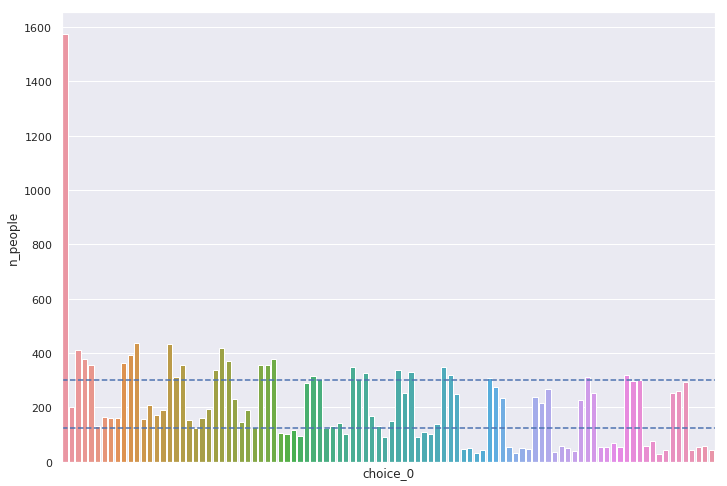

In [68]:
first_wishes = data[["choice_0", "n_people"]]
# total number of people for each day
first_wishes_dist = first_wishes.groupby("choice_0")["n_people"].sum().reset_index()
ax = sns.barplot(data=first_wishes_dist, x="choice_0", y="n_people")
# constraints per day
ax.axhline(300, ls='--')
ax.axhline(125, ls='--');
# clean axis
ax.get_xaxis().set_ticks([]);

### Last wishes

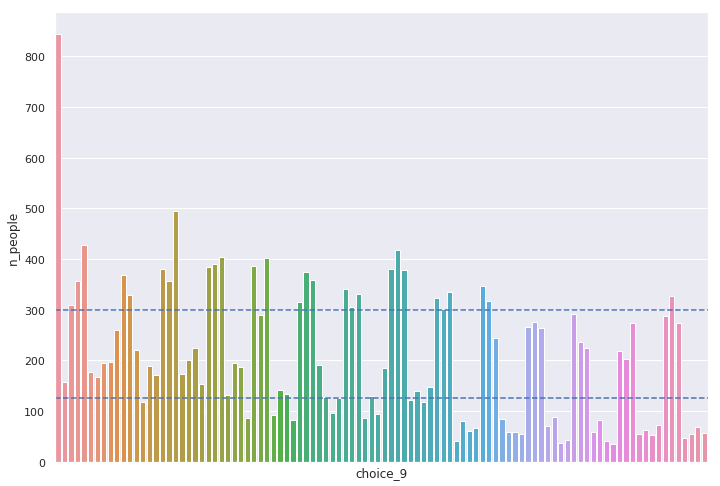

In [69]:
first_wishes = data[["choice_9", "n_people"]]
# total number of people for each day
first_wishes_dist = first_wishes.groupby("choice_9")["n_people"].sum().reset_index()
ax = sns.barplot(data=first_wishes_dist, x="choice_9", y="n_people")
# constraints per day
ax.axhline(300, ls='--')
ax.axhline(125, ls='--')
# clean axis
ax.get_xaxis().set_ticks([]);

### "Potentials" : max number of people that would be attending each day

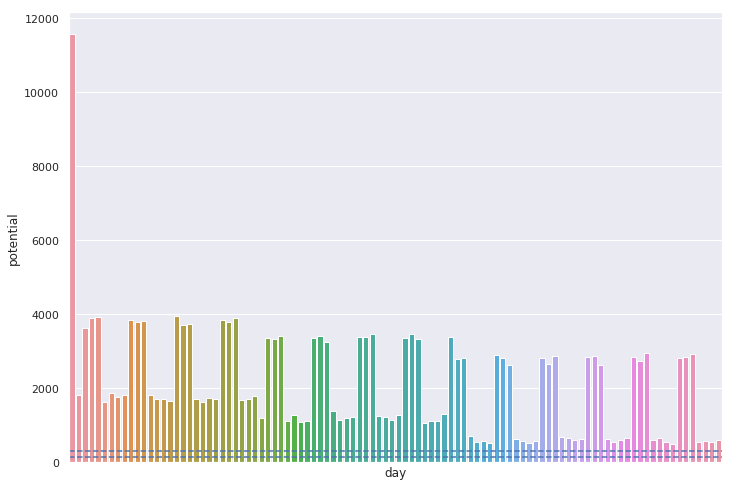

In [8]:
choices = data.drop("n_people", axis=1)
group_sizes = data["n_people"]

potentials = pd.Series(0, index=range(1, 101))

for idx, fam_choices in choices.iterrows():
    potentials.loc[fam_choices] += group_sizes.loc[idx]

plot_data = potentials.reset_index().rename({"index": "day", 0: "potential"}, axis=1)
ax = sns.barplot(data=plot_data, x="day", y="potential")
ax.axhline(300, ls='--')
ax.axhline(125, ls='--')
ax.get_xaxis().set_ticks([]);

### Reservations wrt number of people : Does the size of the family influences the chosen day ?
Moving large groups is more costly than small ones. We are looking for patterns given group sizes (i.e. we expect smaller groups to be more flexible).
<br>
We only consider first and last wishes with the rationale that they represent well the extremum choices one groupe is willing to make. (going during the week vs going during the week-end)

In [95]:
first_wishes = data[["choice_0", "n_people"]]

top_5_per_group = dict()

wishes_by_group = first_wishes.groupby("n_people")["choice_0"].apply(list)
for idx, wishes in wishes_by_group.iteritems():
    wishes = pd.Series(wishes)
    counts = wishes.value_counts()[:5]
    top_5_per_group[idx] = counts.index.tolist()
top_5_per_group

{2: [1, 17, 45, 59, 3],
 3: [1, 10, 11, 26, 54],
 4: [1, 45, 33, 3, 26],
 5: [1, 25, 17, 33, 5],
 6: [1, 4, 88, 25, 12],
 7: [1, 12, 39, 3, 52],
 8: [1, 54, 11, 32, 81]}

In [99]:
last_wishes = data[["choice_9", "n_people"]]

top_5_per_group = dict()

wishes_by_group = last_wishes.groupby("n_people")["choice_9"].apply(list)
for idx, wishes in wishes_by_group.iteritems():
    wishes = pd.Series(wishes)
    counts = wishes.value_counts()[:5]
    top_5_per_group[idx] = counts.index.tolist()
top_5_per_group

{2: [1, 18, 39, 26, 59],
 3: [1, 52, 61, 26, 4],
 4: [1, 24, 26, 17, 31],
 5: [1, 31, 5, 26, 66],
 6: [1, 19, 52, 11, 17],
 7: [1, 19, 39, 11, 45],
 8: [1, 4, 40, 51, 11]}